In [13]:
import os
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
x_train.shape

(50000, 32, 32, 3)

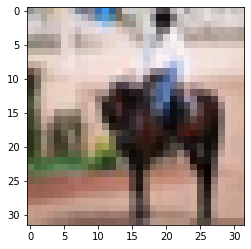

In [4]:
plt.imshow(x_train[11])

In [5]:
x_train[0].max()

255

In [6]:
# Normalize image pixel values
x_train = x_train / 255
x_test = x_test / 255

In [7]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [8]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [9]:
# Prepare one-hot encoded y-values
y_train_cat = to_categorical(y=y_train, num_classes=10)
y_test_cat = to_categorical(y=y_test, num_classes=10)

In [10]:
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [11]:
# Prepare GPU
def prep_gpu():
    phy_gpus = tf.config.list_physical_devices(device_type='GPU')

    for gpu in phy_gpus:
        tf.config.experimental.set_memory_growth(device=gpu, enable=True)

    log_gpus = tf.config.list_logical_devices(device_type='GPU')
    phy_cpus = tf.config.list_physical_devices(device_type='CPU')
    log_cpus = tf.config.list_logical_devices(device_type='CPU')

    print("Physical GPUs: {}\tLogical GPUs: {}\nPhysical CPUs: {}\tLogical CPUs: {}".format(len(phy_gpus),
                                                                                             len(log_gpus),
                                                                                             len(phy_cpus),
                                                                                             len(log_cpus)))

In [14]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
prep_gpu()

Physical GPUs: 1	Logical GPUs: 1
Physical CPUs: 1	Logical CPUs: 1


In [15]:
# Build model
backend.clear_session()
model = Sequential()

# Convolutional layer
model.add(Conv2D(filters=32, kernel_size=(4, 4), input_shape=(32, 32, 3), activation='relu'))
# Pooling layer
model.add(MaxPool2D(pool_size=(2, 2)))

# Convolutional layer
model.add(Conv2D(filters=32, kernel_size=(4, 4), input_shape=(32, 32, 3), activation='relu'))
# Pooling layer
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Create early stopping callback
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 29, 29, 32)        1568      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               410112    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5

In [16]:
# Fit the model
model.fit(x=x_train, y=y_train_cat, epochs=20, validation_data=(x_test, y_test_cat), callbacks=[early_stop], verbose=1)

Epoch 1/20
1563/1563 [==============================] - 7s 4ms/step - accuracy: 0.4646 - loss: 1.4828 - val_accuracy: 0.5570 - val_loss: 1.2422
Epoch 2/20
1563/1563 [==============================] - 6s 4ms/step - accuracy: 0.6042 - loss: 1.1307 - val_accuracy: 0.6075 - val_loss: 1.1166
Epoch 3/20
1563/1563 [==============================] - 6s 4ms/step - accuracy: 0.6552 - loss: 0.9851 - val_accuracy: 0.6572 - val_loss: 0.9985
Epoch 4/20
1563/1563 [==============================] - 6s 4ms/step - accuracy: 0.7006 - loss: 0.8621 - val_accuracy: 0.6633 - val_loss: 0.9756
Epoch 5/20
1563/1563 [==============================] - 6s 4ms/step - accuracy: 0.7315 - loss: 0.7670 - val_accuracy: 0.6711 - val_loss: 0.9899
Epoch 6/20
1563/1563 [==============================] - 6s 4ms/step - accuracy: 0.7613 - loss: 0.6839 - val_accuracy: 0.6570 - val_loss: 1.0912


In [17]:
# Model evaluation
metrics = pd.DataFrame(model.history.history)
print(metrics)

       loss  accuracy  val_loss  val_accuracy
0  1.482786   0.46462  1.242233        0.5570
1  1.130662   0.60422  1.116628        0.6075
2  0.985091   0.65522  0.998476        0.6572
3  0.862056   0.70056  0.975615        0.6633
4  0.767030   0.73146  0.989910        0.6711
5  0.683912   0.76134  1.091212        0.6570


<AxesSubplot:>

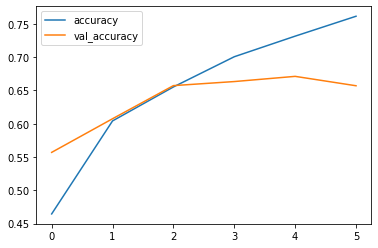

In [19]:
metrics[['accuracy', 'val_accuracy']].plot()

In [20]:
model.evaluate(x_train, y_train_cat)

1563/1563 [==============================] - 4s 2ms/step - accuracy: 0.7632 - loss: 0.6801


[0.6801347136497498, 0.7632200121879578]

In [21]:
model.evaluate(x_test, y_test_cat)

313/313 [==============================] - 1s 2ms/step - accuracy: 0.6569 - loss: 1.0898


[1.0897760391235352, 0.6568999886512756]

In [22]:
# Make predictions and see classification report
y_pred = np.argmax(model.predict(x_test), axis=-1)

In [23]:
print(classification_report(y_true=np.array(y_test), y_pred=y_pred))
print("\n")
print(confusion_matrix(y_true=np.array(y_test), y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.74      0.70      0.72      1000
           1       0.89      0.68      0.77      1000
           2       0.69      0.41      0.52      1000
           3       0.44      0.45      0.45      1000
           4       0.50      0.77      0.61      1000
           5       0.55      0.59      0.57      1000
           6       0.69      0.80      0.74      1000
           7       0.67      0.73      0.70      1000
           8       0.87      0.67      0.76      1000
           9       0.74      0.74      0.74      1000

    accuracy                           0.66     10000
   macro avg       0.68      0.66      0.66     10000
weighted avg       0.68      0.66      0.66     10000



[[705  13  44  38  60  15  17  31  36  41]
 [ 32 679  10  22  15  17  37  24  24 140]
 [ 49   4 413 111 209  76  81  48   5   4]
 [ 12   3  30 453 136 201  98  55   0  12]
 [ 13   1  19  51 774  31  39  62   8   2]
 [  5   1  25 162 105 59